In [12]:
import yaml
import pypsa
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

In [18]:
anchors = {
    'SSE-SP': ['6441'],
    'SCOTEX': ['5912'],
    'SSHARN': ['5946'],
    'FLOWSTH': ['6010', '5250'],
    'SEIMP': ['4977'],
}

In [32]:

def get_line_grouping(
        buses,
        lines,
        boundaries,           # dict: boundary_name -> list of line IDs forming that boundary
        anchor_buses          # dict: boundary_name -> list of known buses for that boundary
                               ):
    """
    n: The network object with n.buses and n.links
    boundaries: e.g. {"Scotland-England": ["Line1", "Line2"], ...}
    anchor_buses: e.g. {"Scotland-England": "BusN1", ...} for BFS to identify 'north' side
    """

    boundary_assignments = {}
    
    # 1) Build a graph of the entire network
    G = nx.Graph()
    
    # Add all buses as nodes
    for bus_name in buses.index:
        G.add_node(bus_name)

    # Add all lines as edges
    for line_id in lines.index:
        bus0 = lines.loc[line_id, 'bus0']
        bus1 = lines.loc[line_id, 'bus1']
        G.add_edge(bus0, bus1, key=line_id)  # store the line_id in "key" or as an attribute

    # 2) We will store the final capacity factor for each line here.
    #    Initialize with None (meaning not assigned yet).
    capacity_factor_for_line = {line_id: None for line_id in lines.index}

    # 3) Iterate over boundaries in the given order (north -> south):
    G_tmp = G.copy()
    for boundary_name, boundary_line_ids in boundaries.items():

        # 3a) Temporarily remove boundary lines from the graph
        #     We'll do this by making a *copy* of G and removing those edges
        #     so as not to destroy the original.
        for line_id in boundary_line_ids:
            # Need to find the buses to remove the correct edge
            bus0 = lines.loc[line_id, 'bus0']
            bus1 = lines.loc[line_id, 'bus1']
            if G_tmp.has_edge(bus0, bus1):
                G_tmp.remove_edge(bus0, bus1)
        
    for boundary_name, boundary_line_ids in boundaries.items():

        # 3b) Find which connected component contains the known "anchor bus"
        connected_buses = list()

        for bus in anchor_buses[boundary_name]:
            # BFS (or connected_component) from anchor_bus in G_tmp
            # This set of buses is the "north side" for this boundary
            connected_buses += list(nx.bfs_tree(G_tmp, source=bus))

        # 3c) Find all lines (edges) that have both endpoints in connected.
        #     We want to assign them the fraction for this boundary
        #     -- or possibly override only if they do not already have a factor assigned,
        #        depending on your logic.
        
        boundary_assignments[boundary_name] = []

        for line_id in lines.index:
            b0 = lines.loc[line_id, 'bus0']
            b1 = lines.loc[line_id, 'bus1']

            if b0 in connected_buses and b1 in connected_buses:
                boundary_assignments[boundary_name].append(line_id)
    
    return boundary_assignments



In [33]:
path = Path.cwd().parent / 'results' / '2022-03-22' / 'network_flex_s_zonal.nc'
n = pypsa.Network(path)

INFO:pypsa.io:Imported network network_flex_s_zonal.nc has buses, carriers, generators, links, loads, storage_units


In [34]:
with open(Path.cwd().parent / 'data' / 'transmission_boundaries.yaml') as f:
    boundaries = yaml.safe_load(f)

In [35]:
groupings = get_line_grouping(
    n.buses, 
    n.links.loc[n.links.carrier != 'interconnector', :],
    boundaries,
    anchors
    )

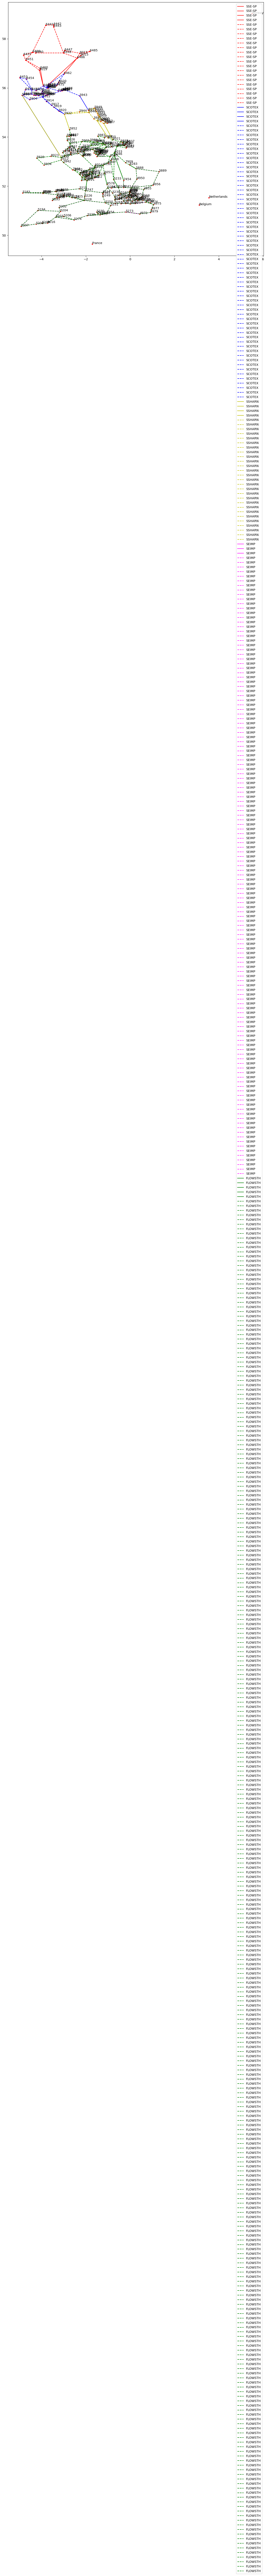

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(n.buses.x, n.buses.y, s=10, color='r')

for name, row in n.buses.iterrows():
    ax.text(
        row.x, row.y, name
    )

colors = ['r', 'b', 'y', 'magenta', 'g']

for (key, item), c in zip(boundaries.items(), colors):
    for l in item:

        ax.plot(
            [n.buses.loc[n.links.loc[l, 'bus0'], 'x'], n.buses.loc[n.links.loc[l, 'bus1'], 'x']],
            [n.buses.loc[n.links.loc[l, 'bus0'], 'y'], n.buses.loc[n.links.loc[l, 'bus1'], 'y']],
            color=c,
            label=key
        )
    
    for l in groupings[key]:
        ax.plot(
            [n.buses.loc[n.links.loc[l, 'bus0'], 'x'], n.buses.loc[n.links.loc[l, 'bus1'], 'x']],
            [n.buses.loc[n.links.loc[l, 'bus0'], 'y'], n.buses.loc[n.links.loc[l, 'bus1'], 'y']],
            color=c,
            label=key,
            linestyle='--'
        )


ax.legend()

plt.show()
